In [1]:
import numpy as np
import pandas as pd

%matplotlib inline

from datetime import date,datetime,timedelta
from dateutil.parser import parse

import json
import re
from glob import glob

import seaborn as sns
import folium as g

import matplotlib.pyplot as plt
from matplotlib import rc
# 한글 폰트 문제 해결
rc('font', family='AppleGothic')
# 차트 축 <- 음수 부호 지원
plt.rcParams['axes.unicode_minus'] = False

In [70]:
import sklearn
from sklearn.datasets import load_iris, load_breast_cancer

from sklearn.model_selection import train_test_split,KFold,StratifiedKFold , cross_val_score, cross_validate,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble  import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import missingno as msno


In [4]:
titanic_df = pd.read_csv('./Data/titanic_train.csv')

In [6]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<AxesSubplot:>

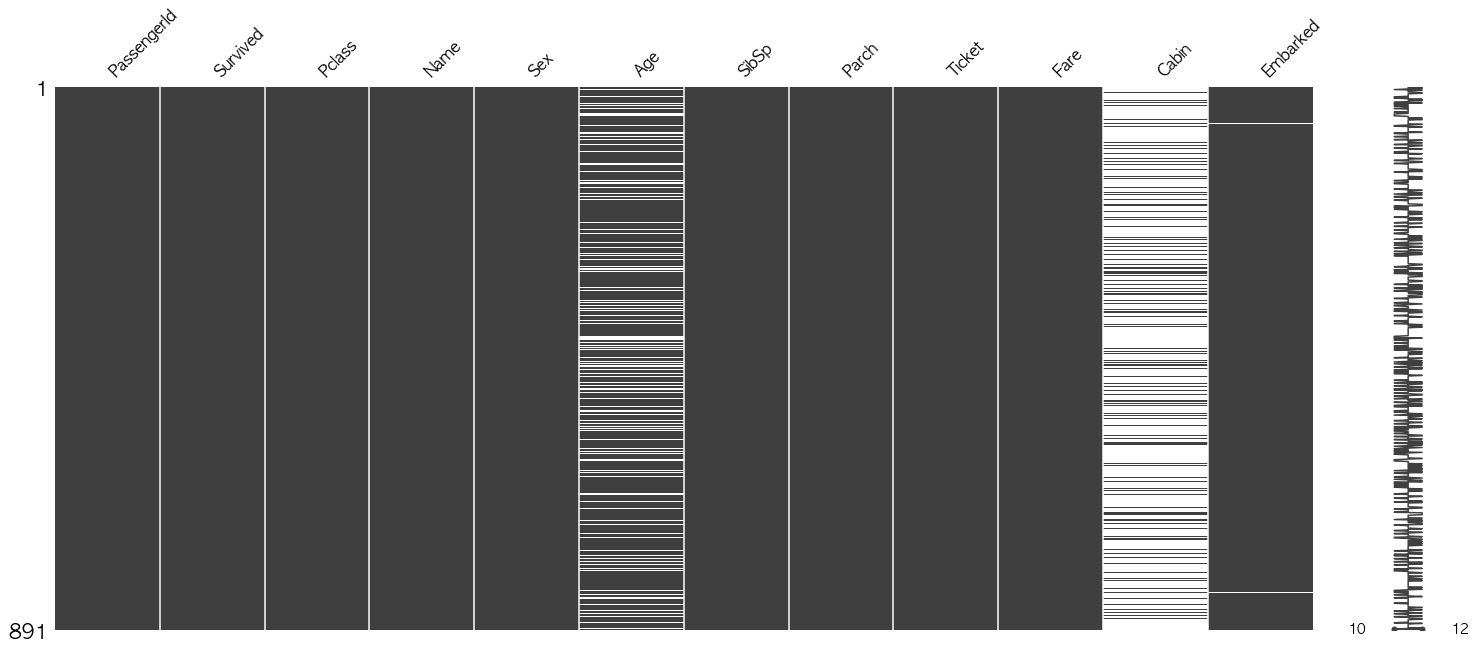

In [7]:
# 결측값 여부 시각화
msno.matrix(titanic_df)

<AxesSubplot:>

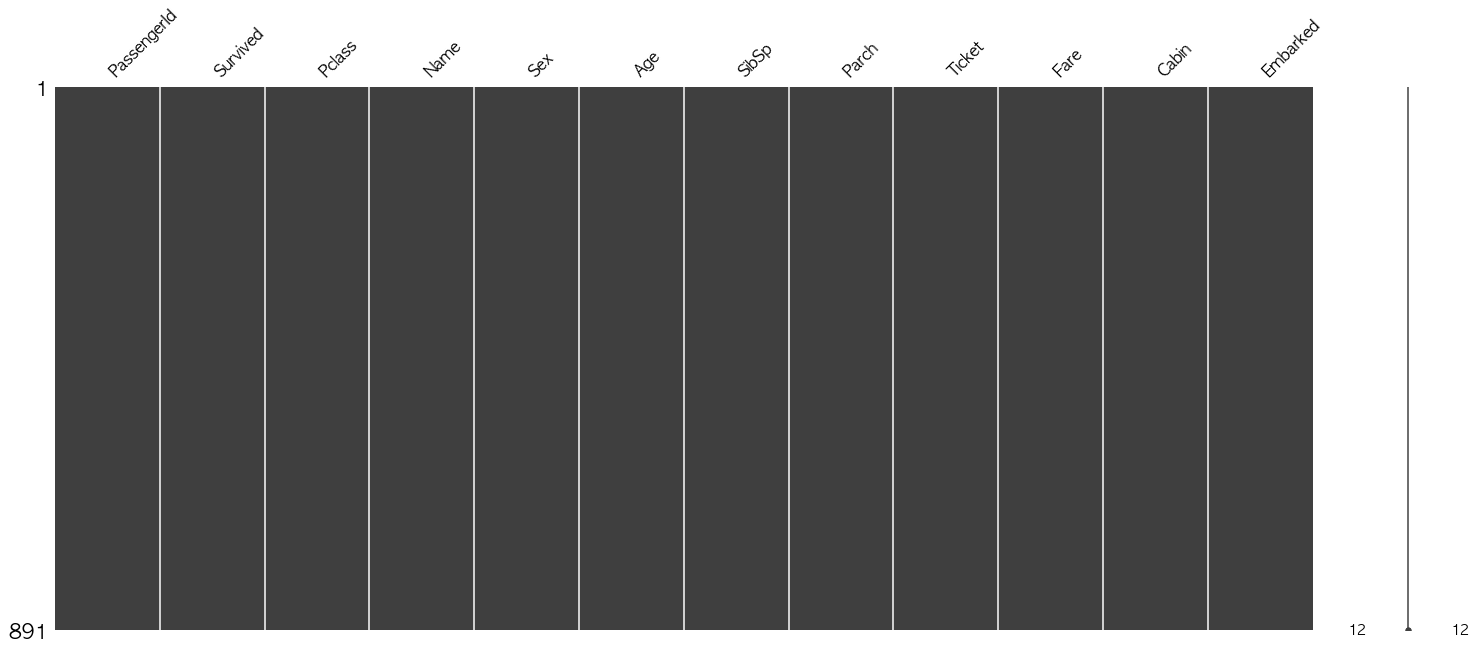

In [16]:
# 결측값 처리
titanic_imputer = SimpleImputer(strategy='mean')
titanic_df['Age'] = titanic_imputer.fit_transform(titanic_df[['Age']])
titanic_df[['Cabin','Embarked']]=titanic_df[['Cabin','Embarked']].fillna('N')
msno.matrix(titanic_df)

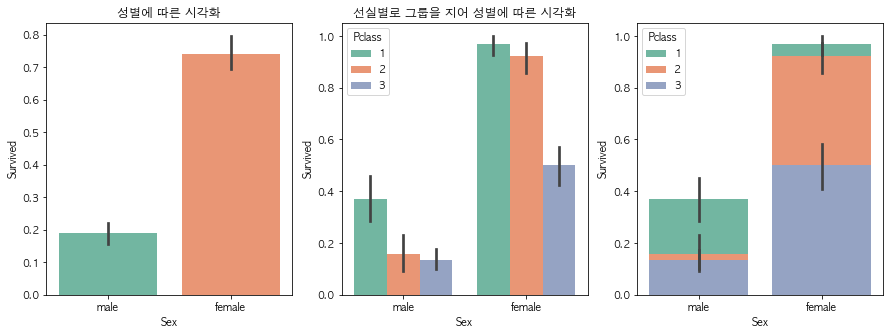

In [25]:
# 성별에 따른 생존 여부
fig = plt.figure(figsize=(15,5))
ax01=fig.add_subplot(1,3,1)
ax01.set_title('성별에 따른 시각화')
sns.barplot(data=titanic_df,x='Sex',y='Survived',palette='Set2')

ax02=fig.add_subplot(1,3,2)
ax02.set_title('선실별로 그룹을 지어 성별에 따른 시각화')
sns.barplot(data=titanic_df,x='Sex',y='Survived',palette='Set2',hue='Pclass')


ax03=fig.add_subplot(1,3,3)
sns.barplot(data=titanic_df,x='Sex',y='Survived',palette='Set2',hue='Pclass',dodge=False)
plt.show()
plt.close()


In [39]:
# 성별에 따른 생존자의 수 
titanic_df.groupby(['Sex','Survived'])['Survived'].count().to_frame()

Survived
Sex    Survived          
female 0               81
       1              233
male   0              468
       1              109

In [42]:
# age에 따른 연령층을 분류 
def age_catogory(s):
    if 0 <= s <= 9:
        loc='10대이하'
    elif 10 <= s <= 19:
        loc='10대'
    elif 20 <= s <= 29:
        loc='20대'
    elif 30 <= s <= 39:
        loc='30대'
    elif 40 <= s <= 49:
        loc='40대'
    elif 50 <= s <= 59:
        loc='50대'
    elif 60 <= s <= 69:
        loc='60대'
    elif 70 <= s <= 79:
        loc='70대'
    else:
        loc='80대이상'
    return loc
titanic_df['AgeGrp'] = titanic_df['Age'].apply(lambda x : age_catogory(x))
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGrp
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,N,S,20대
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,30대
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,N,S,20대
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,30대
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,N,S,30대


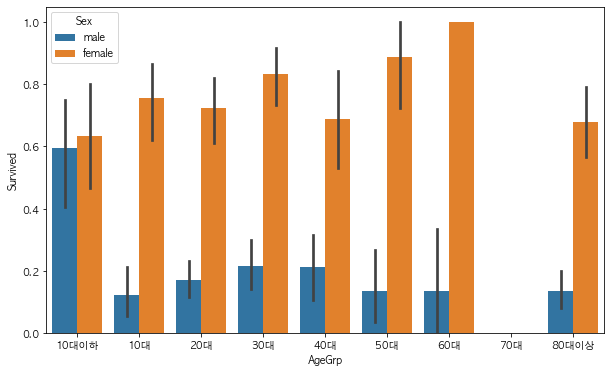

In [55]:
# 나이대별 생존률
fig = plt.figure(figsize=(10,6))
sns.barplot(data=titanic_df,x='AgeGrp',y='Survived',hue='Sex',order=['10대이하','10대','20대','30대','40대','50대','60대','70대','80대이상'])
plt.show()

In [56]:
# 필요없는 컬럼들은 버리자
titanic_df.drop('AgeGrp',axis=1,inplace=True)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,N,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,N,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,N,S


In [59]:
# Feature selection
titanic_subset_df = titanic_df[['Survived','Pclass','Sex','Age','SibSp','Cabin','Embarked']]
titanic_subset_df.head()

,Survived,Pclass,Sex,Age,SibSp,Cabin,Embarked
0,0,3,male,22.0,1,N,S
1,1,1,female,38.0,1,C85,C
2,1,3,female,26.0,0,N,S
3,1,1,female,35.0,1,C123,S
4,0,3,male,35.0,0,N,S


In [69]:
# label encoding
def encode_feature(series):
    encoder = LabelEncoder()
    encoder.fit(series)
    return encoder.transform(series)
    
titanic_subset_df['Sex'] = encode_feature(titanic_subset_df['Sex'])
#titanic_subset_df['Cabin'] = encode_feature(titanic_subset_df['Cabin'].str[0])
titanic_subset_df['Embarked'] = encode_feature(titanic_subset_df['Embarked'])
titanic_subset_df.head()

/var/folders/v3/m9cgmw1d3qs7ppj4ltvx26pc0000gn/T/ipykernel_2471/1352935580.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_subset_df['Sex'] = encode_feature(titanic_subset_df['Sex'])
/var/folders/v3/m9cgmw1d3qs7ppj4ltvx26pc0000gn/T/ipykernel_2471/1352935580.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_subset_df['Embarked'] = encode_feature(titanic_subset_df['Embarked'])


,Survived,Pclass,Sex,Age,SibSp,Cabin,Embarked
0,0,3,1,22.0,1,7,3
1,1,1,0,38.0,1,2,0
2,1,3,0,26.0,0,7,3
3,1,1,0,35.0,1,2,3
4,0,3,1,35.0,0,7,3


#### 학습을 위한 준비
- feature label 데이터셋 추출
- 데이터 분리
- 분류모델 선정 후 학습
- 예측
- 평가
- 교차검증 추가(KFold,cross_val_score,GridSearchCV)

In [74]:
# feature label 분리

titanic_features = titanic_subset_df.iloc[:,~titanic_subset_df.columns.isin(['Survived'])]  
titanic_labels = titanic_subset_df.iloc[:,titanic_subset_df.columns.isin(['Survived'])]  

# Train Test 분리

X_train, X_test, y_train , y_test = train_test_split(titanic_features,titanic_labels,test_size=0.2)

In [73]:
dt_model = DecisionTreeClassifier(random_state=200)
rf_model = RandomForestClassifier(random_state=200)
lr_model = LogisticRegression(random_state=200)

In [77]:
dt_model.fit(X_train,y_train)
y_predict = dt_model.predict(X_test)
print('accuracy of decision tree is:',accuracy_score(y_test,y_predict))

rf_model.fit(X_train,y_train)
y_predict = rf_model.predict(X_test)
print('accuracy of random forest is:',accuracy_score(y_test,y_predict))

lr_model.fit(X_train,y_train)
y_predict = lr_model.predict(X_test)
print('accuracy of logistic regression is:',accuracy_score(y_test,y_predict))




accuracy of decision tree is: 0.7821229050279329
accuracy of random forest is: 0.8268156424581006
accuracy of logistic regression is: 0.7932960893854749


/var/folders/v3/m9cgmw1d3qs7ppj4ltvx26pc0000gn/T/ipykernel_2471/2593695612.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train,y_train)
/Users/iganghui/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
